# Exercise 1

First of all, we import some usefull libraries.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from IPython.display import display, Latex

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["animation.html"] = "jshtml"

We can upload our data and representate it.

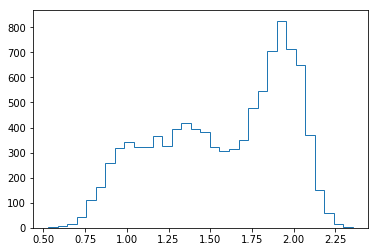

In [2]:
data = np.loadtxt('data/mixture.txt')

plt.hist(data, bins=32, histtype='step', density=False);

Since we don't know which ones are our labels, and that data follows a normal distribution, we're conducting a unsupervised learning method (with gaussian mixture models).

Now, we're diving data into train-test sets.

In [3]:
train_data, test_data = train_test_split(data, test_size=0.2)
train_data = train_data.reshape(-1, 1); test_data = test_data.reshape(-1, 1)

We're implemeting gaussian mixture model with two gaussians (as a try, because we don't really know the number of components in the mixture). Then, we're trying with three gaussians and, finally, we're looking for best number of them.

In [4]:
gaussian_mixture_2 = GaussianMixture(n_components=2, tol=1e-5, n_init=3)
gaussian_mixture_2.fit(train_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=3, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=1e-05, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

If we divide our possible clusters into lentils or ashes, we choose the ashes cluster as the one with smaller average diameter.

Due to the unidentifiability of the parameters, assigning labels to clusters is meaningless (we have to put in "by hand").

In [5]:
ashes = np.min(gaussian_mixture_2.means_[:,0])
lentils = np.max(gaussian_mixture_2.means_[:,0])

display(Latex('With two gaussians, ashes diameter is: %.3f, and lentils\' is: %.3f' %(ashes, lentils)))

<IPython.core.display.Latex object>

But our data could fit better to a three-gaussians model, so we'll try it too.

In [6]:
gaussian_mixture_3 = GaussianMixture(n_components=3, tol=1e-5, n_init=3)
gaussian_mixture_3.fit(train_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=3, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=1e-05, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In order to compare them, we're measuring the performance with _Negative log likelihoood_, implemented with score method from sklearn (it returns the average LL). The smaller that score is, the better.

In [7]:
NLL_2 = -gaussian_mixture_2.score(test_data)
NLL_3 = -gaussian_mixture_3.score(test_data)

display(Latex('NLL for two gaussians is: %.3f, and for three is: %.3f' %(NLL_2, NLL_3)))

<IPython.core.display.Latex object>

Since both result are nearly the same, and cross validation is a time-consuming method (we're only using it on next step), we're applying Akaike Information Criterion, which tries to compensate for the number of parameters that were used to fit the model.

AIC is normalized differently from score method, so we have to rescale it.

In [8]:
AIC_2 = 0.5 * gaussian_mixture_2.aic(train_data)/len(train_data)
AIC_3 = 0.5 * gaussian_mixture_3.aic(train_data)/len(train_data)

display(Latex('AIC for two gaussians is: %.3f, and for three is: %.3f' %(AIC_2, AIC_3)))

<IPython.core.display.Latex object>

Beyesian Information Criterion gives another similar value.

In [9]:
BIC_2 = 0.5 * gaussian_mixture_2.bic(train_data)/len(train_data)
BIC_3 = 0.5 * gaussian_mixture_3.bic(train_data)/len(train_data)

display(Latex('BIC for two gaussians is: %.3f, and for three is: %.3f' %(BIC_2, BIC_3)))

<IPython.core.display.Latex object>

Both values are nearly the same again, but best number of cluster could not to be any of these ones. So, let's try different number of components. We're testing until a maximum of ten clusters.

We're comparing cross validation too, instead we dind't before.

In [10]:
N_clts = 10
gmms = [GaussianMixture(n_components=i, tol=1e-4, max_iter=500, n_init=3) for i in range(1, N_clts+1)]

cvs =  [cross_validate(gm, train_data, y=None, cv=5) for gm in gmms]

for gm in gmms:
    gm.fit(train_data)

Now, we can proceed to plot all calculated scores in order to find the best number of clusters.

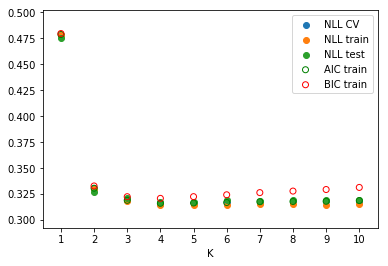

In [11]:
n_samples = len(train_data)
plt.scatter(np.arange(1,N_clts+1), [-c['test_score'].mean() for c in cvs], label='NLL CV');
plt.scatter(np.arange(1,N_clts+1), [-gm.score(train_data) for gm in gmms], label='NLL train');
plt.scatter(np.arange(1,N_clts+1), [-gm.score(test_data) for gm in gmms], label='NLL test');
plt.scatter(np.arange(1,N_clts+1), [0.5*gm.aic(train_data)/n_samples for gm in gmms], label='AIC train', facecolor='none', edgecolors='green');
plt.scatter(np.arange(1,N_clts+1), [0.5*gm.bic(train_data)/n_samples for gm in gmms], label='BIC train', facecolor='none', edgecolors='red');
plt.xticks(np.arange(1,N_clts+1));
plt.xlabel("K");
plt.legend();

We see a minimum around 4 clusters, which may be the best option. So, we're again supposing that biggest diameter is for lentils. That way, other three clusters refer to different diamters of ashes.

As we can see below, now we get a bit bigger diameter for the lentils.

In [12]:
classifier = gmms[3] # Four components

lentils = np.max(classifier.means_[:,0])
lentils_label = np.argmax(classifier.means_[:,0])
ashes = np.sort(np.delete(classifier.means_[:,0], np.argmax(classifier.means_[:,0])))

display(Latex('Lentils diameter is: %.3f' %lentils))

<IPython.core.display.Latex object>

Now, we can display it to show where the lentils are supposed to be.

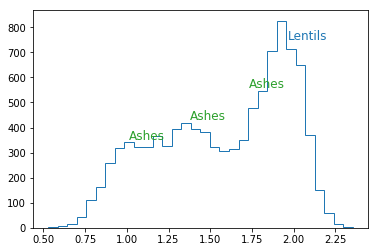

In [13]:
plt.text(lentils, 750, 'Lentils', fontsize = 12, color = '#1f77b4')
plt.text(ashes[0], 350, 'Ashes', fontsize = 12, color = '#2ca02c')
plt.text(ashes[1], 430, 'Ashes', fontsize = 12, color = '#2ca02c')
plt.text(ashes[2], 560, 'Ashes', fontsize = 12, color = '#2ca02c')
plt.hist(data, bins=32, histtype='step', density=False);

And this is on a 1-dimensional plot, where x-axis should be from 0 to 2.3 (it's the diameter). Yellow zone are lentils.

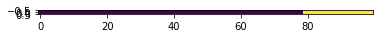

In [14]:
c = np.linspace(0, 2.3, 100)
predicted_out = classifier.predict(c.reshape(-1, 1)).astype(int)

aux = np.zeros(len(c))
aux[np.where(predicted_out == lentils_label)] = 1
aux = np.expand_dims(aux, axis=0) 
plt.imshow(aux)

Results are not really as we expected to (we expected that last gaussian was for the same cluster, lentils). Nevertheless, since we do not have labels, we only can look to the calculated scores.

## Accuracy

Now, we're calcualting accuracy without knowing the labels. In order to do that, we're calculating several predicted labels for each diameter. Then, we're using a voting method to get those most probable labels. Finally, with initial train-test data we're calculating accuracy.

It may not be truly exact, because it's only a measure about coincidence of the classifier each time we execut it.

In [15]:
N_data = len(data); ages = 300
preditions = np.zeros([N_data, ages]) - 1

for age in range(ages):
    positions_train = np.random.choice(range(N_data), int(N_data*0.8), replace = False)
    positions_test = np.delete(range(N_data), positions_train)
    
    train_fold = data[positions_train].reshape(-1, 1)
    test_fold = data[positions_test].reshape(-1, 1)
    
    classifier.fit(train_fold)
    preditions[:, age][positions_test] = classifier.predict(test_fold)

preditions = preditions.astype(int)

Then, we implement voting method.

In [16]:
final_predition = np.zeros(N_data) - 1

for i in range(N_data):
    aux = preditions[i]
    if np.any(aux != -1):
        aux = aux[aux != -1]
        final_predition[i] = np.argmax(np.bincount(aux))

Finally, we generate train-test data and calculate the accuracy. We have to take into account that we may no have predicted labels for all diameters.

In [17]:
train_data, test_data, train_lbl, test_lbl = train_test_split(data, final_predition, test_size=0.2)
train_data = train_data.reshape(-1, 1); test_data = test_data.reshape(-1, 1)

classifier.fit(train_data)
predited = classifier.predict(test_data)

np.count_nonzero(test_lbl == predited) / np.count_nonzero(test_lbl != -1) # No data for test_lbl == -1

0.5175